In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.python.ops.gen_math_ops import sub
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold
import cv2
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.utils.np_utils import to_categorical # convert labels to one-hot-encoding
from sklearn.metrics import accuracy_score
from keras import backend as K 

#### Load Images

Get 300 benign images and 300 malignant images total from the 2020 ISIC Challenge for our train, validation, and test dataset. We will use 70% of our images for training, 15% for validation, and 15% for testing.

In [ ]:
def load_and_crop(image_path, crop_size, normalized=False):
    # image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = cv2.imread(image_path)
    # percent by which the image is resized
    scale_percent = 10
    # calculate the 10 percent of original dimensions
    width = int(image.shape[1] * scale_percent / 100) # dont use, raw images are not in the same size
    height = int(image.shape[0] * scale_percent / 100) # dont use
    # dsize = (width, height)
    dsize = (256,256) # resize to 256 * 256, can use this code to resize the image again
    image = cv2.resize(image, dsize)
    width, height, color_channel = image.shape # get dimensions
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)

cell_types = ['benign','malignant']
cell_inds = np.arange(0, len(cell_types))
benign_data = []
malignant_data = []
x_data = []
y_data = []

# benign
benign_images = glob.glob(os.path.join('/content/drive/MyDrive/ML_Imaging_Final_Project/', 'benign', '*.jpg'))
benign_data += [load_and_crop(image_path, 128, normalized = True) for image_path in benign_images[0:300]]
y_data += [0]*300 # make the total number of images to be 600 (300 benign + 300 mal)

# malignant
malignant_images = glob.glob(os.path.join('/content/drive/MyDrive/ML_Imaging_Final_Project/', 'malignant', '*.jpg'))
malignant_data += [load_and_crop(image_path, 128, normalized = True) for image_path in malignant_images[0:300]]
y_data += [1]*300

# combine benign and malignant
x_data = benign_data + malignant_data

In [ ]:
print('Total number of images:', len(x_data))
print('Total number of labels:', len(y_data))

Total number of images: 600
Total number of labels: 600


In [ ]:
# data frame with all the filenames and labels
df = pd.DataFrame({
    'filename': benign_images[0:300] + malignant_images[0:300],
    'category': y_data
})
df.head()

,filename,category
0,/content/drive/MyDrive/ML_Imaging_Final_Projec...,0
1,/content/drive/MyDrive/ML_Imaging_Final_Projec...,0
2,/content/drive/MyDrive/ML_Imaging_Final_Projec...,0
3,/content/drive/MyDrive/ML_Imaging_Final_Projec...,0
4,/content/drive/MyDrive/ML_Imaging_Final_Projec...,0


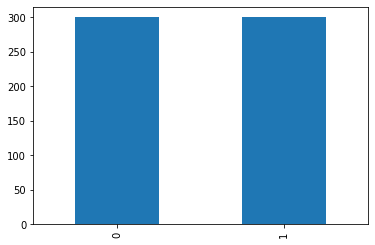

In [ ]:
# visualize total count in data
df['category'].value_counts().plot.bar()

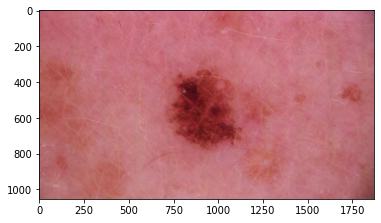

In [ ]:
# see sample image
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)

Display Benign Images


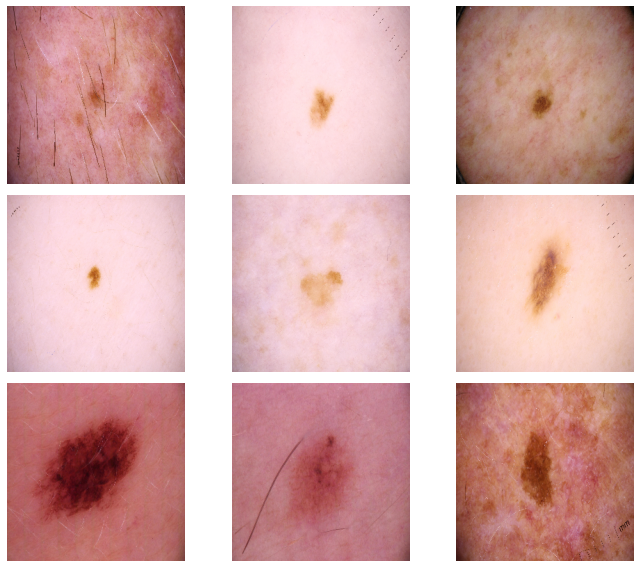

In [ ]:
# visualize benign images 

print('Display Benign Images')

# adjust the size of your images
plt.figure(figsize=(10,8))

# iterate and plot first 9 benign images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = cv2.cvtColor(benign_data[i], cv2.COLOR_BGR2RGB)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# adjust subplot parameters to give specified padding
plt.tight_layout() 

Display Malignant Images


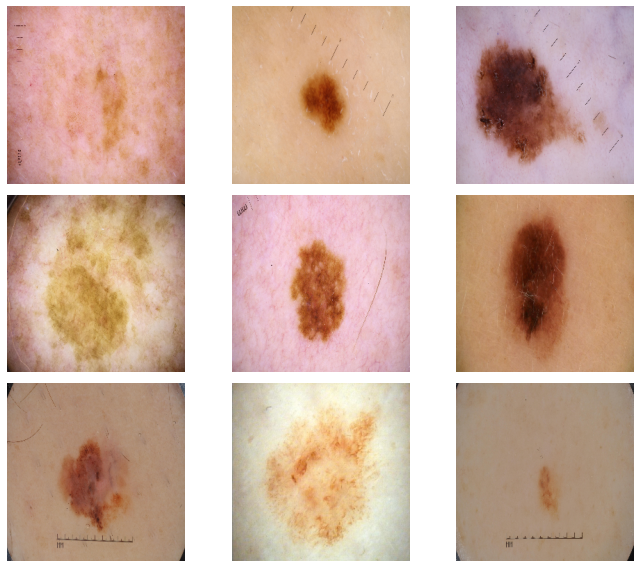

In [ ]:
# visualize malignant images 
print('Display Malignant Images')

# adjust the size of your images
plt.figure(figsize=(10,8))

# iterate and plot first 9 malignant images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = cv2.cvtColor(malignant_data[i], cv2.COLOR_BGR2RGB)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# adjust subplot parameters to give specified padding
plt.tight_layout() 

In [ ]:
# generating train/val/test splits 
# convert 1 to malignant and 0 to benign since we are using class mode = categorical
# df["category"] = df["category"].replace({0: 'benign', 1: 'malignant'})
train_df, validate_df, test_df = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
# train: 360 imgs, shape: 256x256x3/img
x_train = np.array([load_and_crop(x, 128, normalized = True) for x in train_df['filename']])
y_train = np.array(train_df['category']) 

# valid: 120 imgs, shape: 256x256x3/img
x_val = np.array([load_and_crop(x, 128, normalized = True) for x in validate_df['filename']])
y_val = np.array(validate_df['category']) 

# test: 120 imgs, shape: 256x256x3/img
x_test = np.array([load_and_crop(x, 128, normalized = True) for x in test_df['filename']])
y_test = np.array(test_df['category'])

In [ ]:
y_train= to_categorical(y_train, num_classes= 2)
y_val = to_categorical(y_val, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [ ]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(360, 256, 256, 3) (360, 2)
(120, 256, 256, 3) (120, 2)
(120, 256, 256, 3) (120, 2)


In [ ]:
# distribution of labels
print('{} benign images in training'.format(len(train_df.loc[train_df['category'] == 0])))
print('{} malignant images in training'.format(len(train_df.loc[train_df['category'] == 1])))
print('{} benign images in validation'.format(len(validate_df.loc[train_df['category']== 0])))
print('{} malignant images in validation'.format(len(validate_df.loc[train_df['category'] == 1])))
print('{} benign images in testing'.format(len(test_df.loc[train_df['category']== 0])))
print('{} malignant images in testing'.format(len(test_df.loc[train_df['category']== 1])))

180 benign images in training
180 malignant images in training
62 benign images in validation
58 malignant images in validation
62 benign images in testing
58 malignant images in testing


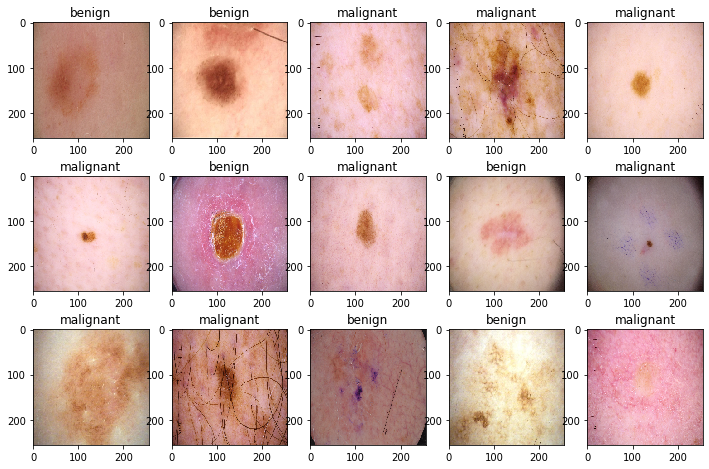

In [ ]:
# display first 15 images of train, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i][0] == 0:
        ax.title.set_text('benign')
    else:
        ax.title.set_text('malignant')
    img = cv2.cvtColor(x_train[i],cv2.COLOR_RGB2BGR)
    plt.imshow(img, interpolation='nearest')

##Evaluation Metrics

In [ ]:
def roc_plot(y_trues, y_preds):
  # Evaluation of the custom_model
  # ROC curve & AUC score
  tpr, fpr, threshold = roc_curve(y_trues, y_preds)
  auc = roc_auc_score(y_trues, y_preds)
  plt.plot(fpr, tpr, label='AUC score=%.3f' % auc, marker='o', markersize=1)
  plt.xlabel('False Positive Rate'); plt.xlim((0, 1))
  plt.ylabel('True Positive Rate'); plt.ylim((0, 1))
  plt.title('ROC Curve')
  plt.legend()

def confusionmatrix(y_trues, y_preds):
  # Confusion matrix
  matrix = confusion_matrix(y_trues, y_preds)
  fig = ConfusionMatrixDisplay(matrix)
  fig.plot()
  plt.title('Confusion Matrix')
  plt.show()

  # Precision, Recall, and F1 score
  tn, fp, fn, tp = matrix[0, 0], matrix[0, 1], matrix[1, 0], matrix[1, 1]
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1_score = 2 * (precision * recall) / (precision + recall)
  eval_tab = pd.DataFrame({'Precision': [precision], 'Recall': [recall], 'F1 Score': [f1_score]})
  print(eval_tab)
  print(classification_report(y_trues, y_preds, target_names = ['benign (Class 0)','malignant (Class 1)']))

## Models

### Baseline Models

#### Simple CNN Model

In [ ]:
# Baseline model without physical layer
image_size = (256, 256, 3) 
custom_model = tf.keras.models.Sequential([tf.keras.layers.Input(image_size),
                                           tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
                                           tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
                                          #  tf.keras.layers.GaussianNoise(0.2),  
                                          #  tf.keras.layers.BatchNormalization(),
                                           tf.keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),      # add max pooling layer
                                           tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
                                           tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
                                          #  tf.keras.layers.BatchNormalization(),
                                           tf.keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),      # add max pooling layer
                                           tf.keras.layers.Flatten(),
                                           tf.keras.layers.Dense(128, activation="relu"),
                                           tf.keras.layers.GaussianDropout(0.3), 
                                           tf.keras.layers.Dense(2, activation="softmax")])

custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                    

In [ ]:
lr = 1e-5
epochs = 150
batch_size = 15
opt = tf.optimizers.Adam(learning_rate=lr)
# to prevent overfitting, stop the learning after 10 epochs and when val_loss value does not decrease
earlystop = EarlyStopping(patience=10)

# reduce learning rate when accuracy doesn't increase for 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

callbacks = [earlystop, learning_rate_reduction]

custom_model.compile(optimizer=opt , loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = custom_model.fit(x_train, y_train, epochs=epochs, verbose = 1, validation_data=(x_val, y_val))

Epoch 1/150
12/12 [==============================] - 14s 308ms/step - loss: 0.6765 - accuracy: 0.5333 - val_loss: 0.6771 - val_accuracy: 0.6333
Epoch 2/150
12/12 [==============================] - 2s 203ms/step - loss: 0.6578 - accuracy: 0.5861 - val_loss: 0.6726 - val_accuracy: 0.5500
Epoch 3/150
12/12 [==============================] - 2s 204ms/step - loss: 0.6351 - accuracy: 0.6472 - val_loss: 0.6706 - val_accuracy: 0.5917
Epoch 4/150
12/12 [==============================] - 2s 204ms/step - loss: 0.6270 - accuracy: 0.6639 - val_loss: 0.6724 - val_accuracy: 0.5917
Epoch 5/150
12/12 [==============================] - 2s 206ms/step - loss: 0.6276 - accuracy: 0.6472 - val_loss: 0.6766 - val_accuracy: 0.6000
Epoch 6/150
12/12 [==============================] - 2s 205ms/step - loss: 0.6179 - accuracy: 0.6361 - val_loss: 0.6673 - val_accuracy: 0.5833
Epoch 7/150
12/12 [==============================] - 2s 207ms/step - loss: 0.6184 - accuracy: 0.6583 - val_loss: 0.6789 - val_accuracy: 0.575

In [ ]:
# save baseline simple cnn model
baseline_model_json = custom_model.to_json()

with open("baseline_model.json", "w") as json_file:
    json_file.write(baseline_model_json)
    
# serialize weights to HDF5
custom_model.save_weights("baseline_model.h5")
print("Saved model to disk")

Saved model to disk


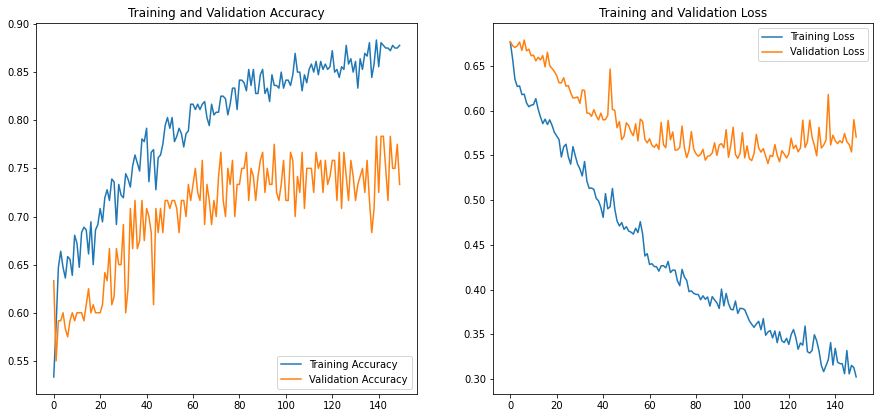

In [ ]:
# plot train and validation loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# evaluate model
y_pred = np.argmax(custom_model.predict(x_test), axis=1)
acc = custom_model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 72ms/step - loss: 0.6295 - accuracy: 0.7083


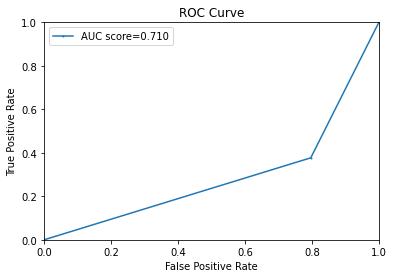

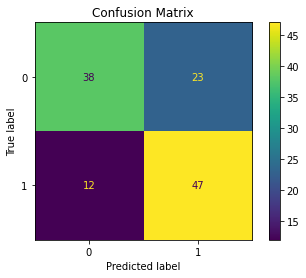

   Precision   Recall  F1 Score
0   0.671429  0.79661  0.728682
                     precision    recall  f1-score   support

   benign (Class 0)       0.76      0.62      0.68        61
malignant (Class 1)       0.67      0.80      0.73        59

           accuracy                           0.71       120
          macro avg       0.72      0.71      0.71       120
       weighted avg       0.72      0.71      0.71       120



In [ ]:
# ROC curve and confusion matrix
y_labels = np.argmax(y_test.astype(int),axis=1)
roc_plot(y_labels, y_pred)
confusionmatrix(y_labels, y_pred)

In [ ]:
# Clear memory, because of memory overload
del custom_model
K.clear_session()

#### ResNet50 model

Try to see if ResNet50 model with data augmentation improves performance. The model ends up being overfit so we will not use this model.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.,
        zoom_range=0.,
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

Train_Datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
#Train_Datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
Val_Datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
Test_Datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)

In [ ]:
# resnet model 

resnet_model = ResNet50(include_top=True,
                  weights= None,
                  input_tensor=None,
                  input_shape=image_size,
                  pooling='avg',
                  classes=2)

resnet_model.compile(optimizer = opt ,loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
#datagen.fit(x_train)
epochs=75
resnet_history = resnet_model.fit(Train_Datagen.flow(x_train, y_train, batch_size=batch_size),
                         validation_data=(x_val, y_val),
                         epochs=epochs, verbose=1, workers=4, callbacks = callbacks)


# resnet_history = resnet_model.fit(x_train, y_train, validation_data = (x_val, y_val),
#                          epochs=epochs, verbose=1, workers=4, callbacks = callbacks)

Epoch 1/75
24/24 [==============================] - 20s 534ms/step - loss: 0.7588 - accuracy: 0.6278 - val_loss: 0.7073 - val_accuracy: 0.5083 - lr: 5.0000e-06
Epoch 2/75
24/24 [==============================] - 12s 485ms/step - loss: 0.5531 - accuracy: 0.7167 - val_loss: 0.6942 - val_accuracy: 0.5083 - lr: 5.0000e-06
Epoch 3/75
24/24 [==============================] - 12s 485ms/step - loss: 0.5503 - accuracy: 0.7056 - val_loss: 0.7081 - val_accuracy: 0.4917 - lr: 5.0000e-06
Epoch 4/75
24/24 [==============================] - 12s 485ms/step - loss: 0.5124 - accuracy: 0.7389 - val_loss: 0.6959 - val_accuracy: 0.4917 - lr: 5.0000e-06
Epoch 5/75
24/24 [==============================] - 12s 486ms/step - loss: 0.5178 - accuracy: 0.7194 - val_loss: 0.6991 - val_accuracy: 0.4917 - lr: 5.0000e-06
Epoch 6/75
24/24 [==============================] - ETA: 0s - loss: 0.4853 - accuracy: 0.7694
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
24/24 [=======================

In [ ]:
# save model
# serialize model to JSON
resnet50_json = resnet_model.to_json()

with open("resnet50.json", "w") as json_file:
    json_file.write(resnet50_json)
    
# serialize weights to HDF5
resnet_model.save_weights("resnet50.h5")
print("Saved model to disk")

Saved model to disk


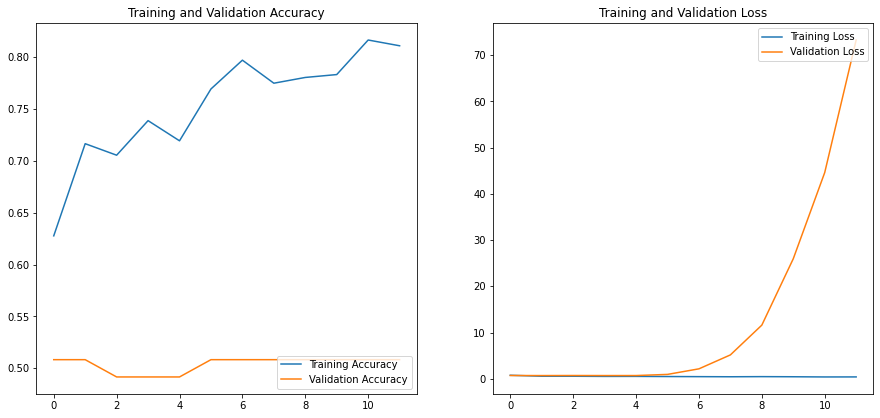

In [ ]:
# plot train and validation loss
acc = resnet_history.history['accuracy']
val_acc = resnet_history.history['val_accuracy']
loss = resnet_history.history['loss']
val_loss = resnet_history.history['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Test set accuracy
y_pred = np.argmax(resnet_model.predict(x_test), axis=1)
acc = resnet_model.evaluate(x_test, y_test)

4/4 [==============================] - 1s 236ms/step - loss: 75.7775 - accuracy: 0.4917


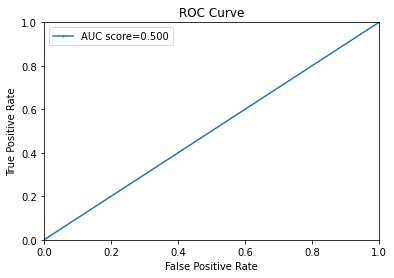

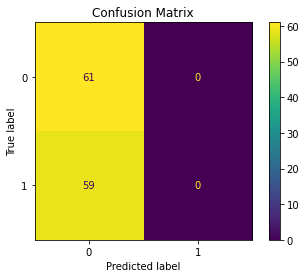

   Precision  Recall  F1 Score
0        NaN     0.0       NaN
                     precision    recall  f1-score   support

   benign (Class 0)       0.51      1.00      0.67        61
malignant (Class 1)       0.00      0.00      0.00        59

           accuracy                           0.51       120
          macro avg       0.25      0.50      0.34       120
       weighted avg       0.26      0.51      0.34       120



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [ ]:
# Model Evaluation
y_labels = np.argmax(y_test.astype(int),axis=1)
roc_plot(y_labels, y_pred)
confusionmatrix(y_labels, y_pred)

In [ ]:
del resnet_model
K.clear_session()

#### BGR Physical Layer Model 

In [ ]:
# B, G, R filters
class BGR_Filter(tf.keras.layers.Layer):
    def __init__(self, is_train=False):
        # code here
        super(BGR_Filter, self).__init__()
        self.is_train = is_train

    def build(self, input_shape):
        # initialize BGR weight with 0 mean 0.05 std
        weight_init = tf.random_normal_initializer(0,0.05)
        # code here
        self.bgrfilter = tf.keras.layers.Conv2D(filters = 1,kernel_size = (1,1), use_bias = False, kernel_initializer= weight_init, trainable=self.is_train)
        #tf.Variable(initial_value=weight_init(shape=(input_shape[-1], )), dtype='float32' ,trainable=self.is_train)

    def call(self, inputs):
        # code here
        #inputs = inputs* self.weight
        output = self.bgrfilter(inputs)
        #output = tf.reshape(tf.reduce_sum(inputs, axis = -1), [64,64,1])
        return output

In [ ]:
bgr_model = tf.keras.models.Sequential([tf.keras.layers.Input(image_size),
                                           # code here
                                           BGR_Filter(is_train = True),
                                           tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
                                           tf.keras.layers.Conv2D(16, 3, 2, padding="same", activation="relu"),
                                          #  tf.keras.layers.GaussianNoise(0.2),  
                                          #  tf.keras.layers.BatchNormalization(),
                                           tf.keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),
                                           tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
                                           tf.keras.layers.Conv2D(16, 3, 2, padding="same", activation="relu"),
                                          #  tf.keras.layers.BatchNormalization(),
                                           tf.keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),
                                           tf.keras.layers.Flatten(),
                                           tf.keras.layers.Dense(128, activation="relu"),
                                           tf.keras.layers.GaussianDropout(0.2), 
                                           tf.keras.layers.Dense(2, activation="softmax")])
  
bgr_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bgr__filter (BGR_Filter)    (None, 256, 256, 1)       3         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        2320      
                                                        

In [ ]:
lr = 5e-5
opt = tf.optimizers.Adam(learning_rate=lr)
bgr_model.compile(optimizer=opt , loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs=150
bgr_history = bgr_model.fit(x_train,y_train, epochs=epochs, verbose = 1, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/150
12/12 [==============================] - 4s 201ms/step - loss: 0.6916 - accuracy: 0.4972 - val_loss: 0.6919 - val_accuracy: 0.4917 - lr: 5.0000e-05
Epoch 2/150
12/12 [==============================] - 2s 127ms/step - loss: 0.6896 - accuracy: 0.5000 - val_loss: 0.6911 - val_accuracy: 0.4917 - lr: 5.0000e-05
Epoch 3/150
12/12 [==============================] - 2s 126ms/step - loss: 0.6876 - accuracy: 0.5000 - val_loss: 0.6900 - val_accuracy: 0.4917 - lr: 5.0000e-05
Epoch 4/150
12/12 [==============================] - 2s 127ms/step - loss: 0.6854 - accuracy: 0.5194 - val_loss: 0.6887 - val_accuracy: 0.5167 - lr: 5.0000e-05
Epoch 5/150
12/12 [==============================] - 1s 126ms/step - loss: 0.6819 - accuracy: 0.5306 - val_loss: 0.6869 - val_accuracy: 0.5083 - lr: 5.0000e-05
Epoch 6/150
12/12 [==============================] - 2s 126ms/step - loss: 0.6772 - accuracy: 0.5806 - val_loss: 0.6833 - val_accuracy: 0.5167 - lr: 5.0000e-05
Epoch 7/150
12/12 [=====================

In [ ]:
# print BGR weights after training
bgr_model.get_weights()[0]

array([[[[-0.10497732],
         [-0.02994923],
         [ 0.03670643]]]], dtype=float32)

In [ ]:
# save model
# serialize model to JSON
#bgr_json = bgr_model.to_json()

#with open("bgr.json", "w") as json_file:
#    json_file.write(bgr_json)
    
# serialize weights to HDF5
bgr_model.save_weights("bgr.h5")
print("Saved model to disk")

Saved model to disk


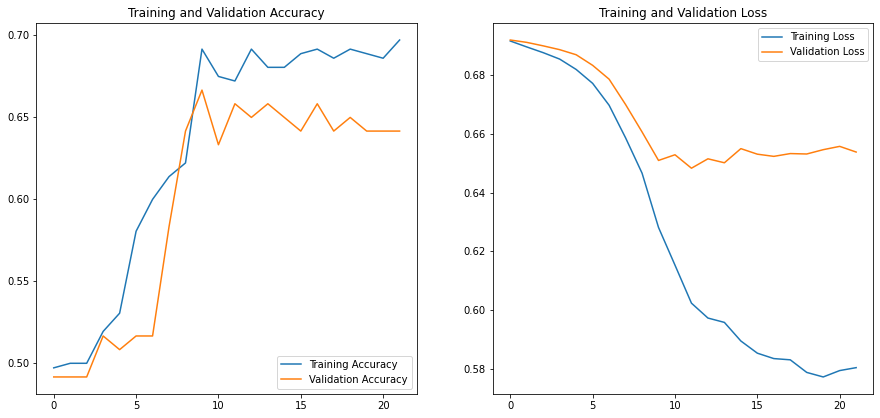

In [ ]:
# plot train and validation loss
acc = bgr_history.history['accuracy']
val_acc = bgr_history.history['val_accuracy']
loss = bgr_history.history['loss']
val_loss = bgr_history.history['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Test set accuracy
y_pred = np.argmax(bgr_model.predict(x_test), axis=1)
acc = bgr_model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 39ms/step - loss: 0.6852 - accuracy: 0.6333


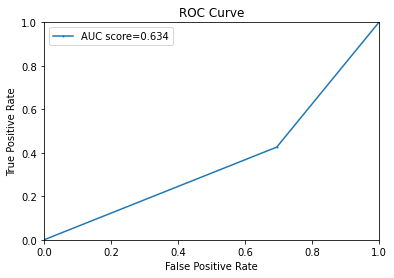

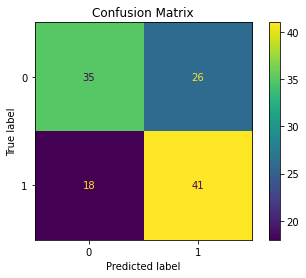

   Precision    Recall  F1 Score
0    0.61194  0.694915  0.650794
                     precision    recall  f1-score   support

   benign (Class 0)       0.66      0.57      0.61        61
malignant (Class 1)       0.61      0.69      0.65        59

           accuracy                           0.63       120
          macro avg       0.64      0.63      0.63       120
       weighted avg       0.64      0.63      0.63       120



In [ ]:
# Model Evaluation
y_labels = np.argmax(y_test.astype(int),axis=1)
roc_plot(y_labels, y_pred)
confusionmatrix(y_labels, y_pred)

In [ ]:
del bgr_model
K.clear_session()

#### Illumination Physical Layer

In [ ]:
# BGR to gray
x_val_gray = []
x_train_gray = []
x_test_gray = []

for image in x_val:
  x_val_gray += [cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)]

print(len(x_val_gray), x_val_gray[0].shape)

for image in x_train:
  x_train_gray += [cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)]

print(len(x_train_gray), x_train_gray[0].shape)

for image in x_test:
  x_test_gray += [cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)]

print(len(x_test_gray), x_test_gray[0].shape)

120 (256, 256)
360 (256, 256)
120 (256, 256)


In [ ]:
wavelength = .5e-3 # units are mm; assuming green light
delta_x = 0.5*wavelength # let's sample at nyquist rate
num_samples = 256

# in real world, microscope samples are 3D and have thickness, which introduce a phase shift to the optical field
# For simplicity, let's further assume the sample thickness and amplitude are inversely correlated, which means the thicker the sample is,
# the more light it absorb.
def convert_images(sample_amplitude):
    sample_phase = 1 - sample_amplitude
    optical_thickness = 20 * wavelength
    return sample_amplitude * np.exp(1j * sample_phase*optical_thickness/wavelength)

x_train_digital = convert_images(np.array(x_train_gray))
x_val_digital = convert_images(np.array(x_val_gray))
x_test_digital = convert_images(np.array(x_test_gray))

In [ ]:
def crop_center(sample, cropx, cropy):
    y,x = sample.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return sample[starty:starty+cropy,startx:startx+cropx]

# Define the spatial coordinates of the sample
# code here
num_samples = 256
starting_coordinate = (-num_samples/2) * delta_x
ending_coordinate = (num_samples/2 - 1) * delta_x

# make linspace, meshgrid as needed
# code here
x = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx, yy = np.meshgrid(x, y)

# define total range of spatial frequency axis, 1/mm
# code here
f_range = int(1/delta_x)
num_samples =  256
delta_fx = f_range/num_samples

# make linspace, meshgrid as needed
# code here
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xxf, yyf = np.meshgrid(xf, yf)

# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
# Let's make the lens transfer function diameter 1/4th the total spatial frequency axis coordinates.
# code here
p = 0.25
d =int((ending_coordinate - starting_coordinate+1) * p)
r = d/2

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
# code here
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2+(yyf)**2)
trans[np.where(dist<r)]=1
plane_wave_angle_xy = np.array([[0,0], [10,0], [10,10], [0,10], [-10,10], [-10,0], [-10,-10], [0,-10], [10,-10]]) * np.pi/180
def return_illumination_data(sample):
    illumination_data = np.zeros((64, 64, 9))
    # code here
    for i, plane_wave_angle in enumerate(plane_wave_angle_xy):
        # Define plane waves
        # code here
        plane_wave_angle_x = plane_wave_angle[0]
        plane_wave_angle_y = plane_wave_angle[1]
        illumination_plane_wave = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))
        
        # Define field emerging from sample
        # code here
        emerging_field = np.multiply(illumination_plane_wave, sample)
        #plt.imshow(np.abs(emerging_field))

        # Take 2D fourier transform of sample
        # code here
        fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

        # Create filtered sample spectrum with center crop (64 x 64)
        # trans: only within desired radius is 1
        # so we can crop the outer part
        # code here
        
        filtered_sample = np.multiply(fourier_field, trans)
        centered_filtered_sample = crop_center(filtered_sample, 64, 64)

        # Propagate filtered sample spectrum to image plane
        # code here
        inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(centered_filtered_sample))

        # save the intensity of inverse_fourier_field
        # code here
        detected_field = np.square(np.abs(inverse_fourier_field))
        illumination_data[:,:,i] = detected_field

    return illumination_data

In [ ]:
x_train_illumination = np.zeros((len(x_train),64,64,9))
x_val_illumination = np.zeros((len(x_val),64,64,9))
x_test_illumination = np.zeros((len(x_val),64,64,9))
for i in range(len(x_train_illumination)):
    x_train_illumination[i] = return_illumination_data(x_train_digital[i])
for i in range(len(x_val_illumination)):
    x_val_illumination[i] = return_illumination_data(x_val_digital[i])
for i in range(len(x_test_illumination)):
    x_test_illumination[i] = return_illumination_data(x_test_digital[i])

In [ ]:
class Illumination(tf.keras.layers.Layer):
    def __init__(self, is_train=False):
        # code here
        super(Illumination, self).__init__()
        self.is_train = is_train

    def build(self, input_shape):
        # initialize illumination weight with 0 mean 0.05 std
        weight_init = tf.random_normal_initializer(0,0.05)
        # code here
        self.illumination = tf.keras.layers.Conv2D(filters = 1,kernel_size = (1,1), use_bias = False, kernel_initializer= weight_init, trainable=self.is_train)

    def call(self, inputs):
        # code here
        output = self.illumination(inputs)
        return output

In [ ]:
image_size =(64, 64, 9)
illum_model = tf.keras.models.Sequential([tf.keras.layers.Input(image_size),
                                           Illumination(is_train = True),
                                           tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
                                           tf.keras.layers.Conv2D(16, 3, 2, padding="same", activation="relu"),
                                          #  tf.keras.layers.GaussianNoise(0.2),  
                                           tf.keras.layers.BatchNormalization(),
                                           tf.keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),
                                           tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
                                           tf.keras.layers.Conv2D(16, 3, 2, padding="same", activation="relu"),
                                           tf.keras.layers.BatchNormalization(),
                                           tf.keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),
                                           tf.keras.layers.Flatten(),
                                           tf.keras.layers.Dense(128, activation="relu"),
                                           tf.keras.layers.GaussianDropout(0.2), 
                                           tf.keras.layers.Dense(2, activation="softmax")])
  
illum_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 illumination_1 (Illuminatio  (None, 64, 64, 1)        9         
 n)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        160       
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                      

In [ ]:
lr = 1e-5
opt = tf.optimizers.Adam(learning_rate=lr)
illum_model.compile(optimizer=opt , loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
illum_history = illum_model.fit(x_train_illumination,y_train, epochs=150, verbose = 1,
                    validation_data=(x_val_illumination, y_val))

Epoch 1/150
12/12 [==============================] - 1s 42ms/step - loss: 0.8679 - accuracy: 0.6361 - val_loss: 0.6524 - val_accuracy: 0.6167
Epoch 2/150
12/12 [==============================] - 0s 21ms/step - loss: 0.8414 - accuracy: 0.6528 - val_loss: 0.6452 - val_accuracy: 0.6167
Epoch 3/150
12/12 [==============================] - 0s 18ms/step - loss: 0.7799 - accuracy: 0.6556 - val_loss: 0.6475 - val_accuracy: 0.5750
Epoch 4/150
12/12 [==============================] - 0s 18ms/step - loss: 0.8269 - accuracy: 0.6472 - val_loss: 0.6495 - val_accuracy: 0.5667
Epoch 5/150
12/12 [==============================] - 0s 18ms/step - loss: 0.7561 - accuracy: 0.6806 - val_loss: 0.6516 - val_accuracy: 0.5750
Epoch 6/150
12/12 [==============================] - 0s 21ms/step - loss: 0.8820 - accuracy: 0.6500 - val_loss: 0.6502 - val_accuracy: 0.5917
Epoch 7/150
12/12 [==============================] - 0s 21ms/step - loss: 0.7748 - accuracy: 0.6694 - val_loss: 0.6475 - val_accuracy: 0.6000
Epoch 

In [ ]:
# save model
# serialize model to JSON
#illum_json = illum_model.to_json()

#with open("illum.json", "w") as json_file:
#    json_file.write(illum_json)
    
# serialize weights to HDF5
illum_model.save_weights("illum.h5")
print("Saved model to disk")

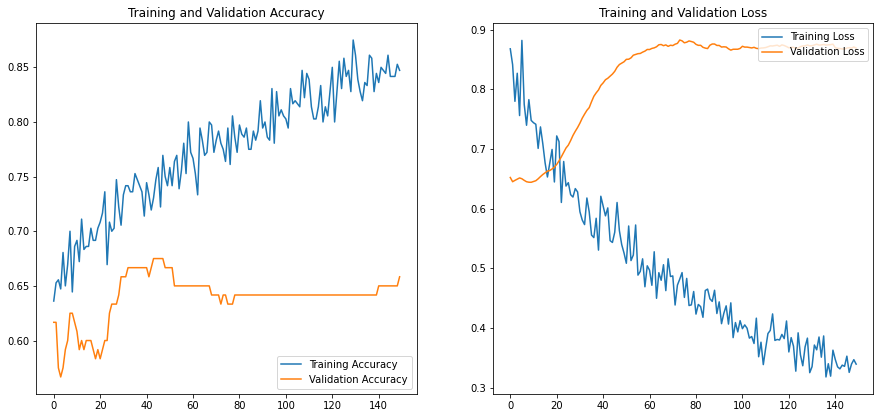

In [ ]:
# plot train and validation loss
acc = illum_history.history['accuracy']
val_acc = illum_history.history['val_accuracy']
loss = illum_history.history['loss']
val_loss = illum_history.history['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Test set accuracy
y_pred = np.argmax(illum_model.predict(x_test_illumination), axis=1)
acc = illum_model.evaluate(x_test_illumination, y_test)

4/4 [==============================] - 0s 8ms/step - loss: 0.7780 - accuracy: 0.6500


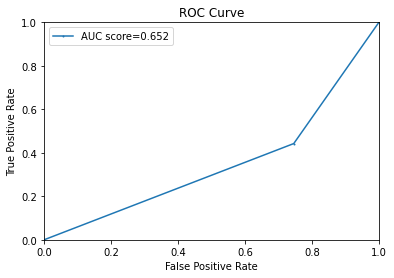

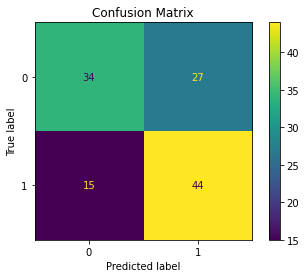

   Precision    Recall  F1 Score
0   0.619718  0.745763  0.676923
                     precision    recall  f1-score   support

   benign (Class 0)       0.69      0.56      0.62        61
malignant (Class 1)       0.62      0.75      0.68        59

           accuracy                           0.65       120
          macro avg       0.66      0.65      0.65       120
       weighted avg       0.66      0.65      0.65       120



In [ ]:
y_labels = np.argmax(y_test.astype(int),axis=1)
roc_plot(y_labels, y_pred)
confusionmatrix(y_labels, y_pred)

In [ ]:
del illum_model
K.clear_session()

#### Gaussian Kernel Physical Layer

In [ ]:
# create gaussian kernel
def gkern(l=7, sig=2):
  ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
  gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
  kernel = np.outer(gauss, gauss)
  return kernel / np.sum(kernel)

In [ ]:
kernels = [gkern(l=k_size, sig = 2)*k_size/2 for k_size in [10, 25, 50, 100, 200]]

<Figure size 432x288 with 0 Axes>

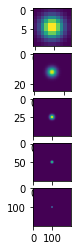

In [ ]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(5,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
for i in range(len(kernels)):
  axarr[i].imshow(kernels[i])


In [ ]:
# this operation will be done of each one of the five kernels
from scipy.signal import convolve2d
x_train_blurred = [convolve2d(p1_gray, kernels[0], boundary='symm', mode = 'same') for p1_gray in x_train_gray]
x_train_blurred = np.array(x_train_blurred)
x_val_blurred = [convolve2d(p1_gray, kernels[0], boundary='symm', mode = 'same') for p1_gray in x_val_gray]
x_val_blurred = np.array(x_val_blurred)
## for other kernels, simply change kernels[0] to kernels[i] where i is from 1 to 4, and use x_trained_blurred as the input

# try last blur kernel
x_train_blurred_last = [convolve2d(p1_gray, kernels[4], boundary='symm', mode = 'same') for p1_gray in x_train_gray]
x_train_blurred_last = np.array(x_train_blurred)
x_val_blurred_last = [convolve2d(p1_gray, kernels[4], boundary='symm', mode = 'same') for p1_gray in x_val_gray]
x_val_blurred_last = np.array(x_val_blurred)

In [ ]:
image_size = (256, 256, 1)
blur_model = tf.keras.models.Sequential([tf.keras.layers.Input(image_size),
                                           tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
                                           tf.keras.layers.Conv2D(16, 3, 2, padding="same", activation="relu"),
                                          #  tf.keras.layers.GaussianNoise(0.2),  
                                           tf.keras.layers.BatchNormalization(),
                                           tf.keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),
                                           tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
                                           tf.keras.layers.Conv2D(16, 3, 2, padding="same", activation="relu"),
                                           tf.keras.layers.BatchNormalization(),
                                           tf.keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),
                                           tf.keras.layers.Flatten(),
                                           tf.keras.layers.Dense(128, activation="relu"),
                                           tf.keras.layers.GaussianDropout(0.2),  
                                           tf.keras.layers.Dense(2, activation="softmax")])

blur_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        2

In [ ]:
x_train_blurred= np.expand_dims(x_train_blurred, axis=-1)

In [ ]:
x_val_blurred = np.expand_dims(x_val_blurred, axis=-1)

In [ ]:
blur_model.compile(optimizer=opt , loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
blur_history = blur_model.fit(x_train_blurred,y_train, epochs=75, verbose = 1, validation_data=(x_val_blurred, y_val))

Epoch 1/75
12/12 [==============================] - 3s 159ms/step - loss: 0.9462 - accuracy: 0.6250 - val_loss: 0.7207 - val_accuracy: 0.5083
Epoch 2/75
12/12 [==============================] - 1s 108ms/step - loss: 0.6872 - accuracy: 0.7583 - val_loss: 0.6888 - val_accuracy: 0.4750
Epoch 3/75
12/12 [==============================] - 1s 107ms/step - loss: 0.5732 - accuracy: 0.6889 - val_loss: 0.7197 - val_accuracy: 0.5167
Epoch 4/75
12/12 [==============================] - 1s 106ms/step - loss: 0.5062 - accuracy: 0.7556 - val_loss: 0.6814 - val_accuracy: 0.5167
Epoch 5/75
12/12 [==============================] - 1s 107ms/step - loss: 0.4577 - accuracy: 0.7528 - val_loss: 0.6798 - val_accuracy: 0.5583
Epoch 6/75
12/12 [==============================] - 1s 108ms/step - loss: 0.3759 - accuracy: 0.7972 - val_loss: 0.6957 - val_accuracy: 0.5083
Epoch 7/75
12/12 [==============================] - 1s 108ms/step - loss: 0.4558 - accuracy: 0.7472 - val_loss: 0.6888 - val_accuracy: 0.5250
Epoch 

In [ ]:
# save model
# serialize model to JSON
blur_json = blur_model.to_json()

with open("blur.json", "w") as json_file:
    json_file.write(blur_json)
    
# serialize weights to HDF5
blur_model.save_weights("blur.h5")
print("Saved model to disk")

Saved model to disk


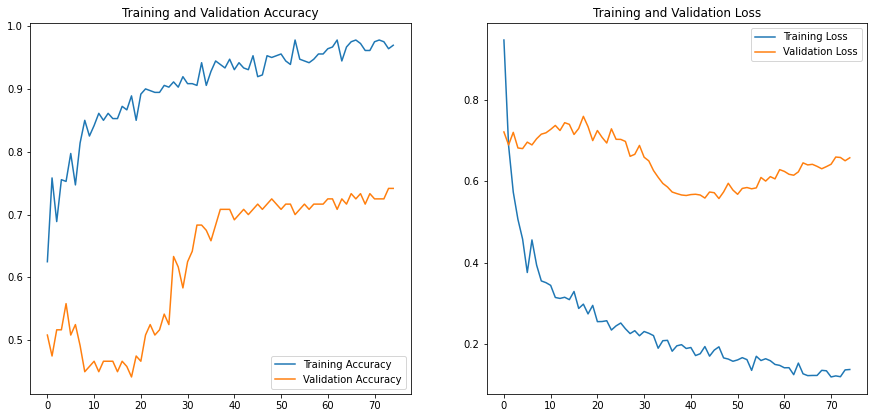

In [ ]:
# plot train and validation loss
acc = blur_history.history['accuracy']
val_acc = blur_history.history['val_accuracy']
loss = blur_history.history['loss']
val_loss = blur_history.history['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
x_test_blurred = [convolve2d(p1_gray, kernels[0], boundary='symm', mode = 'same') for p1_gray in x_test_gray]
x_test_blurred = np.array(x_test_blurred)
x_test_blurred = np.expand_dims(x_test_blurred, axis=-1)

In [ ]:
y_pred = np.argmax(blur_model.predict(x_test_blurred), axis=1)
acc = blur_model.evaluate(x_test_blurred, y_test)

4/4 [==============================] - 0s 32ms/step - loss: 0.7507 - accuracy: 0.7417


In [ ]:
# try to evaluate model using regular x_test instead of x_test_blurred
y_pred = np.argmax(blur_model.predict(x_test), axis=1)
acc = blur_model.evaluate(x_test, y_test)

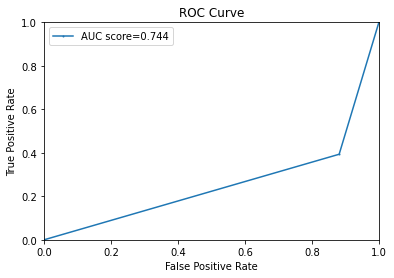

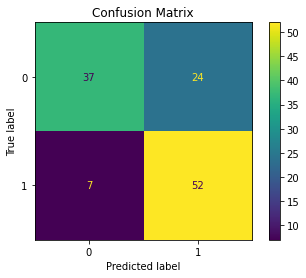

   Precision    Recall  F1 Score
0   0.684211  0.881356   0.77037
                     precision    recall  f1-score   support

   benign (Class 0)       0.84      0.61      0.70        61
malignant (Class 1)       0.68      0.88      0.77        59

           accuracy                           0.74       120
          macro avg       0.76      0.74      0.74       120
       weighted avg       0.76      0.74      0.74       120



In [ ]:
roc_plot(y_labels, y_pred)
confusionmatrix(y_labels, y_pred)

In [ ]:
# evaluate model using last blur kernel
x_train_blurred_last = np.expand_dims(x_train_blurred_last, axis=-1)
x_val_blurred_last =  np.expand_dims(x_val_blurred_last, axis=-1)
blur_history = blur_model.fit(x_train_blurred_last,y_train, epochs=75, verbose = 1, validation_data=(x_val_blurred, y_val))

In [ ]:
y_pred = np.argmax(blur_model.predict(x_test), axis=1)
acc = blur_model.evaluate(x_test, y_test)

In [ ]:
roc_plot(y_labels, y_pred)
confusionmatrix(y_labels, y_pred)

In [ ]:
# see which training image has more blur by plotting the first image of the first and last kernels
plt.imshow(x_train_blurred[0])
plt.imshow(x_train_blurred_last[0])

In [ ]:
del blur_model
K.clear_session()